---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
copyright: 
  holder: Matthew Reda
  year: 2024
citation: true
---

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#| hide
from budget_optimizer.optimizer import *
from budget_optimizer.utils.model_classes import *
import matplotlib.pyplot as plt

# budget_optimizer

> Budget optimizer for nested MMMs

This library is to help wrap custom models for use in budget optimization. It is designed to work with nested MMMs, where the budget is allocated to different media channels and the performance is measured by multiple KPIs which are fed into a downstream revenue model. 

For example in a typical MMM, the budget is allocated to different media channels and the performance is measured by sales, website visits, and brand awareness. Website visits and brand awareness impact sales, website visits are impacted by brand awareness. So the effects of changing the budget flow through the nested KPIs.

The library is designed to work with any model that can be wrapped in a `Model` class. The `Model` class should have needs a `predict` method that takes a dictionary of parameters and returns an xarray dataset with the model prediction for that model's kpi. These model classes can be composed in a `NestedModel` class which will flow the predictions into the next stage of the model.

Model loading and functions to define how budget translates into model inputs must be defined in a seperate file. Included in the folder with the model artifacts in a file called `model_config.py` which should contain the following functions:

- `model_loader` - a function that takes a path and returns a `Model` object
- `budget_to_model_inputs` - a function that a budget and model object and returns a dataset of model inputs

:::{.callout-note collapse="True"}

## How to define the model_config.py file

See the example in the `example_files` folder for an example of how to define these functions for a simple model.
:::

## Developer Guide

If you are new to using `nbdev` here are some useful pointers to get you started.

### Install budget_optimizer in Development mode

```sh
# make sure budget_optimizer package is installed in development mode
$ pip install -e .

# make changes under nbs/ directory
# ...

# compile to have changes apply to budget_optimizer
$ nbdev_prepare
```

## Usage

### Installation

Install latest from the GitHub [repository][repo]:

```sh
$ pip install git+https://github.com/redam94/budget_optimizer.git
```

or from [conda][conda]

```sh
$ conda install -c redam94 budget_optimizer
```

or from [pypi][pypi]


```sh
$ pip install budget_optimizer
```


[repo]: https://github.com/redam94/budget_optimizer
[docs]: https://redam94.github.io/budget_optimizer/
[pypi]: https://pypi.org/project/budget_optimizer/
[conda]: https://anaconda.org/redam94/budget_optimizer

### Documentation

Documentation can be found hosted on this GitHub [repository][repo]'s [pages][docs]. Additionally you can find package manager specific guidelines on [conda][conda] and [pypi][pypi] respectively.

[repo]: https://github.com/redam94/budget_optimizer
[docs]: https://redam94.github.io/budget_optimizer/
[pypi]: https://pypi.org/project/budget_optimizer/
[conda]: https://anaconda.org/redam94/budget_optimizer

## How to use

```{.python}
## file: example_files/model_1/model_config.py
import xarray as xr
from pathlib import Path
import numpy as np
from budget_optimizer.utils.model_classes import _Model, Budget

INITIAL_BUDGET: Budget = dict(a=2., b=3.)

class SimpleModel(_Model):
  """
  Simple model that just adds the two variables a and b.
  This can be as complex as you want as long as it has a predict method
  that takes an xarray Dataset and returns an xarray DataArray and 
  a contributions method that takes an xarray Dataset and returns an xarray Dataset.
  
  Ideally, the model should also have data that defines the initial data that the
  model was trained on. You can wrap cutom models or functions in a class like this.
  """
  def __init__(self, data: xr.Dataset = None):
    self.data = data
    
  def predict(self, x: xr.Dataset) -> xr.DataArray:
    x = x.copy()
    x["prediction"] = x["a"] + x["b"]
    return x["prediction"]
  
  def contributions(self, x: xr.Dataset) -> xr.Dataset:
    return x

def budget_to_data(budget: Budget, model: _Model) -> xr.Dataset:
    data = model.data.copy()
    for key, value in budget.items():
        data[key] = value/INITIAL_BUDGET[key]*data[key]
    return data
  
def model_loader(path: Path) -> _Model:
    rng = np.random.default_rng(42)
    data_a = xr.DataArray(np.exp(1+rng.normal(0, .1, size=156)), dims='time', coords={"time": np.arange(1, 157)})
    data_b = xr.DataArray(np.exp(2+rng.normal(0, .1, size=156)), dims='time', coords={"time": np.arange(1, 157)})
    return SimpleModel(data = xr.Dataset({"a": data_a, "b": data_b}))
```

In [ ]:
class RevenueModel(BaseBudgetModel):
    def __init__(self, model_name: str, model_kpi: str, model_path: str):
        super().__init__(model_name, model_kpi, model_path)    

In [ ]:
MODEL_NAME = "Revenue Model"
MODEL_KPI = "Revenue"
MODEL_PATH = "../example_files/model_1"
model = RevenueModel(MODEL_NAME, MODEL_KPI, MODEL_PATH)
budget_1 = dict(a=1, b=2)
budget_2 = dict(a=2, b=1)
outcome_budget_1 = model.predict(budget_1)
outcome_budget_2 = model.predict(budget_2)

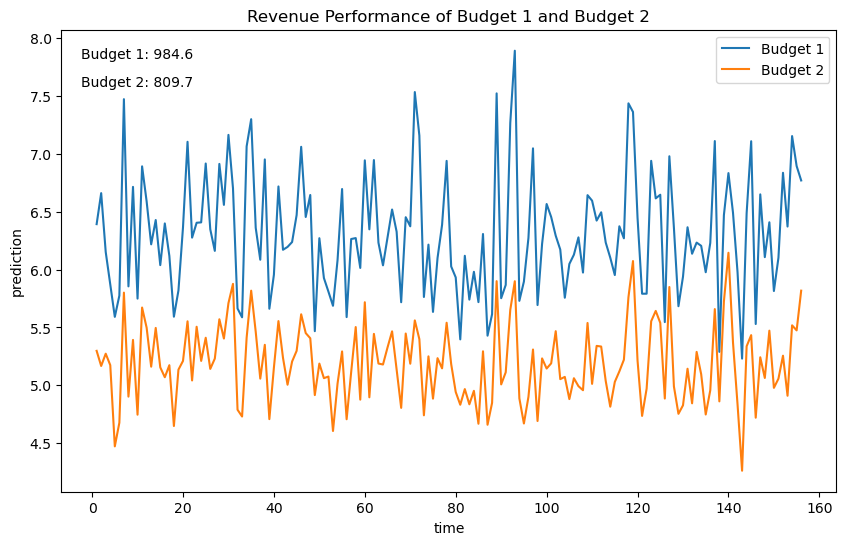

In [ ]:
#| echo: false
#| label: fig-revenue-performance
#| fig-cap: Revenue Performance of Budget 1 and Budget 2
plt.figure(figsize=(10, 6))
outcome_budget_1.plot(label="Budget 1")
outcome_budget_2.plot(label="Budget 2")
plt.title("Revenue Performance of Budget 1 and Budget 2")
plt.annotate(
  f"Budget 1: {outcome_budget_1.sum().values:0.1f}", 
  (10, 7.7), textcoords="offset points", 
  xytext=(0,10), ha='center')
plt.annotate(
  f"Budget 2: {outcome_budget_2.sum().values:0.1f}", 
  (10, 7.7), textcoords="offset points", 
  xytext=(0,-10), ha='center')
plt.legend();